# <font color=navy> 9. Bayesian Multi-Armed Bandit

*Adapted from an example by Ted Dunning of MapR Technologies*

> 슬롯머신이	열	대(10 Bandits)가	있다고	하자.	각	기계는	상금을	획득할	수	있는	미지의	확률을	가지고	있다(상금은	같고	오직	확률만	다르다).	어떤	기계는	확률이	후한	반면,	어떤	것은	그렇지	않다.	물론	그	확률이	얼마인지	모른다.	매번	승률이 높을	것으로	예상되는	하나의	기계를	선택함으로써	우리의	전략은	승률을	극대화하는	것이다. 


<img src="http://sanghyukchun.github.io/images/post/96-4.jpg">


## 9.1  탐색(exploration) vs. 활용(exploitation)

- 만약 우리가 꽤 좋은 결과를 돌려주는 기계를 찾아냈다면 좋은 결과를 유지하기 위해 그 기계를 계속 사용할 것인지(exploitation) 아니면 더 좋은 결과를 얻을 거라는 희망으로 다른 기계를 찾아볼 것인가(exploration)? 

<img src="https://cxl.com/wp-content/uploads/2015/09/Screen-Shot-2015-09-04-at-4.12.27-PM-1.jpg" width=70%>



<img src="https://cxl.com/wp-content/uploads/2015/09/Screen-Shot-2015-09-04-at-4.24.17-PM-1.jpg">

#### A/B Test
- 실험 후 그 실험 결과를 100% 활용하는 **discrete한 testing 방법**
- 비교적 짧은 시간 동안 순수하게 새로운 가능성을 탐색(exploration)을 행한 후, 한번 의사결정 후에는 해당 variation(ex.웹페이지 디자인)을 모든 방문자에게 노출시켜 활용(exploitation)
- 위의 그림에서 3개의 variation에 대한 AB Teting이 각 variation을 전체의 각각 1/3에 해당하는 고객들에게 동일하게 노출
- 의사결정후 선택된 variation을 한번에 모두 적용할 경우, **기존 고객의 불평을 사는 등의 역효과**를 불러일으킬 가능성이 있다.
- Exploration을 위한 데이터를 수집하는 과정에서 **열등한 variation(option)을 필요 이상으로 많이 노출**할 수 있다.\
    ex) option c가 처음 몇번만 해봐도 별로인걸 아는 경우 바로 빼고 싶어도 정해진 횟수를 채울 때 까지는 그러지 못한다.

    

#### Multi-armed bandit
-  실험(exploration)과 활용(exploitation)을 동시에 할 수 있는 알고리즘으로 **continuous**한 testing 방법
- 고객의 **feedback을 순간순간 반영**하여, 그 규모를 확대 혹은 축소함으로써, 열등한 variation의 노출은 줄이고, 우월한 variation의 노출은 늘린다.
-  기회비용과 regret function을  **최소화**하는 방향으로 학습이 진행



#### 응용 분야 

- **인터넷	디스플레이	광고**:	회사는	방문자에서	노출할	여러	광고안을	마련했지만	어느	광고	전략이	매출을	극대화할지는	모른다.	이것은	A/B	테스트와	유사하지만	성공하지	못할	광고안을	자연스럽게	줄여나가는	장점이 있다.

- **금융**:	시간에	따라	수익률	프로파일이	달라지고	있는	상황에서	어떤	주식	옵션이	최고의	수익률을	줄	것인가?
- **임상실험**:	어느	연구원은	가능한	여러	가지	임상치료	실험	중	부작용을	최소화하는	최고의	임상치료는	무엇인지	알고	싶다.



## 9.2 솔루션 제안
- *Online algorithm*: **연속적으로 계속 업데이트** 되는다는 의미 (마치 **강화학습**처럼)
- 알고리즘은 아무것도 모르는 무지의 상태에서 시작
- 시스템을 테스트하면서 데이터를 얻고 **그때마다 최선의 행위가 무엇이고 최악의 행위가 무엇인지 배운다.** 


#### Bayesian Bandit (Thompson Sampling)

- 각 벤디트가 이길 확률에 대한 사전확률분포: unif(0,1) = Beta(1,1)으로 가정하고 시작

1. 각 밴디트 $b$에 대해 사전확률분포 $\text{Beta}(\alpha_0, \beta_0)$ 에서 랜덤 표본 $X_b$를 추출한다.
2. 표본값이 가장 큰 밴디트를 선택한다. 즉, $B = \text{arg} \max{X_b}$를 고른다.
3. 밴디트 $B$결과를 관측하고, 밴디트$B$에 대한 사전확률을 업데이트한다.
    - 관측된 결과 $X$(win 또는 lose, 각각의 1과 0으로 대신한다)는 이항분포를 따르므로 사후확률은 $\text{Beta} (\alpha = \alpha_0+X, \beta = \beta_0 + 1 - X)$다.
    - 이 Posterior 를 다음 Prior로 하여 반복진행한다.
4. 1로 돌아간다.(반복)

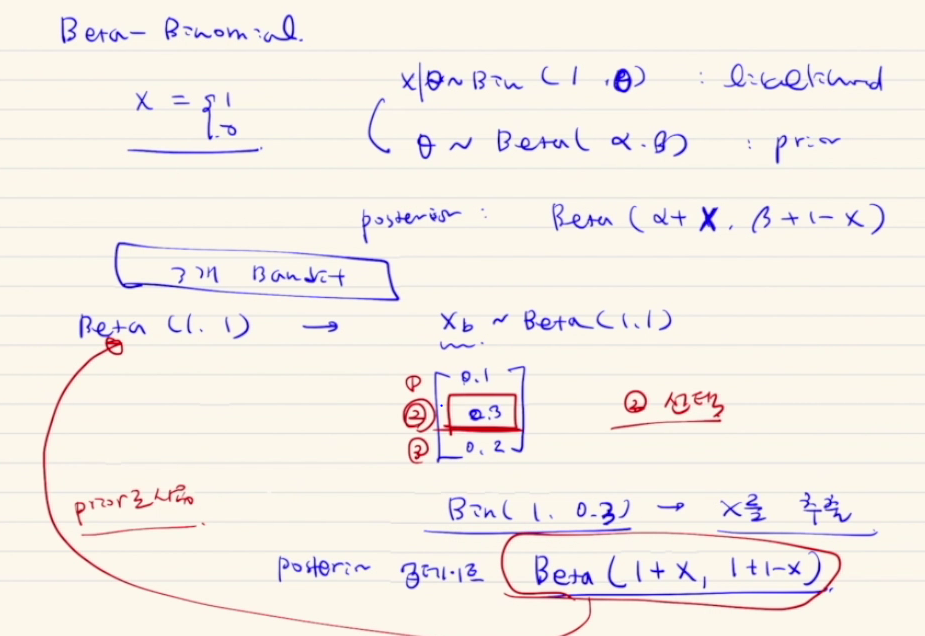

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt



rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):  # 한번 당기는거
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):

            #사전확률에서 샘플링하여 이길 확률이 가장 높은 밴디트 선택
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins)) # Beta(1 + X, 1 + N - X)
            
            #선택된 밴디트에서 머신 당기기
            result = self.bandits.pull(choice) # 0 or 1
            
            #사전확률과 스코어 업데이트
            self.wins[choice] += result # 선택된 밴디트를 성공한 횟수- 0 or 1 더하기
            self.trials[choice] += 1 # 선택된 밴디트를 시도한 횟수 - 항상 1 더하기
            bb_score[k] = result # 성공 여부 - 0 or 1
            self.N += 1 # 전체 시도 횟수 - 항상 1 더하기
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return 

In [2]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

In [3]:
bayesian_strat.sample_bandits(10)

In [4]:
bayesian_strat.choices
# 선택된 머신

array([0., 0., 2., 2., 2., 2., 2., 2., 1., 2.])

In [5]:
bayesian_strat.bb_score
# 이겼는지 졌는지

array([1., 0., 1., 1., 1., 0., 1., 1., 1., 1.])

In [6]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

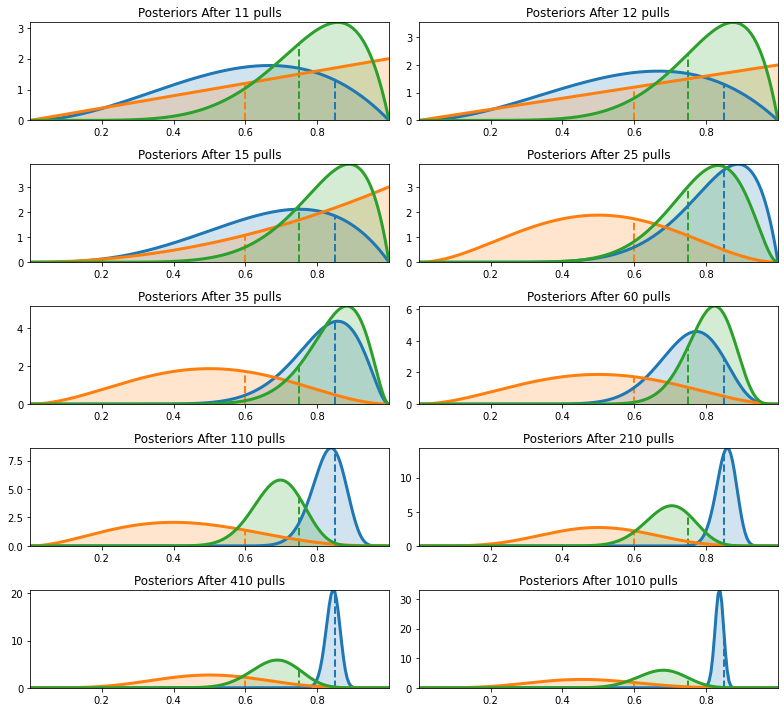

In [7]:
draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

In [2]:
from IPython.core.display import HTML
HTML(filename = "BanditsD3.html")

#### 다양한 밴디트 선택 알고리즘 
0. **Thompson Sampling**: **Binomial-Beta** 케이스를 이용한 Sampling. 가장 흔히 쓰임
1. **랜덤(random)**:	시험할	밴디트를	임의로	선택한다.	선택을	하지	못하면	중단한다. (비교를 위한 baseline)

3. **베이지안-UCB	알고리즘(Bayes-UCB algorithm)**:	가장	큰	점수를	가진	밴디트를	선택한다.	그	**점수는	사후확률의	분위수	값**이다.\
   ex) 0.99를 가지는 x축의 upper limit값이 가장 큰 밴디트를 선택
4. **사후확률의	평균(mean of posterior)**:	**가장	큰	사후확률	평균을	가진	밴디트를	선택**한다.	이것이	인간	참여자가	할	법한	전략이다.
5. **최대비율(largest proportion)**:	현재	**최대의	관측승률**을	가진	밴디트를	선택한다.

Thompson Sampling
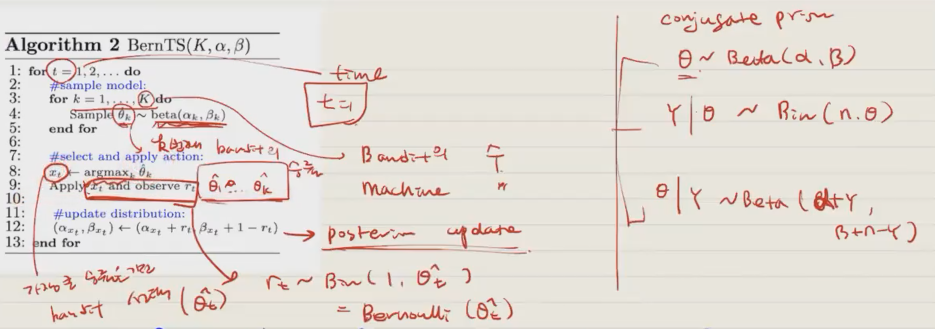

앱실론 greddy
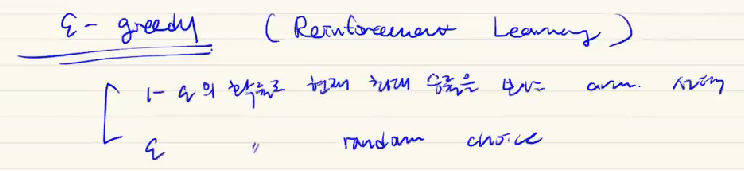

### 9.2.2 적합의 척도
- $T$라운드 후, 처음부터 최고의 밴디트를 선택했을 경우와 우리의 선택해온 전략을 비교하여 **총 손실**(total regret)을 정의

$$
\begin{eqnarray} R_T & = & \sum_{i=1}^{T}{\left( w_{opt} - w_{B(i)} \right)} \\  & = & T\cdot w_{opt}- \sum_{i=1}^{T}{w_{B(i)}} \end{eqnarray}
$$
-  $w_{opt}$: 최고의 밴디트 승률
- $w_{B(i)}$는 $i$번째 라운드 후 선택된 밴디트의 성공(prize)확률



In [9]:
figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max() # 최고의 밴디트 승률
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes, 
            max_mean,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

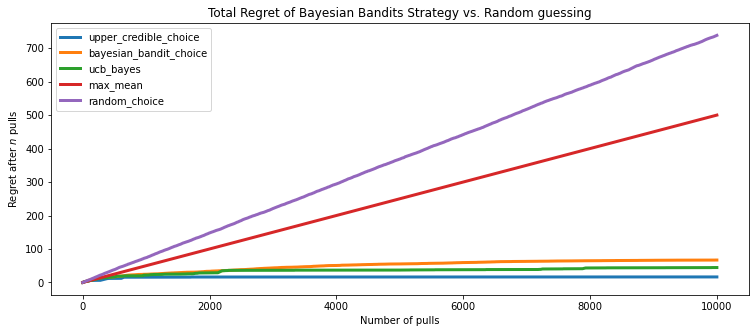

In [10]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)
    
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");
# bayesian_bandit_choice -> Thompson Sampling

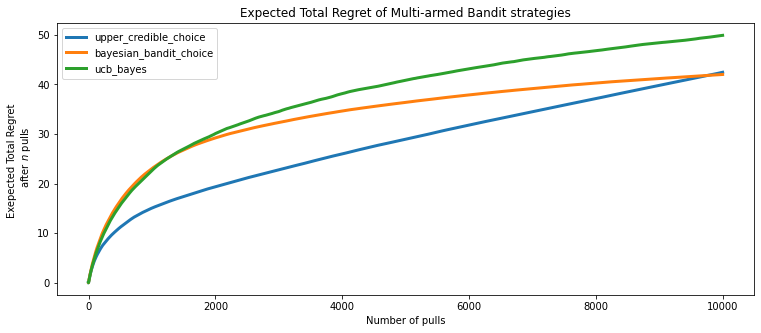

In [12]:
#this can be slow, so I recommend NOT running it. 

trials = 500
expected_total_regret = np.zeros((10000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hidden_prob, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat]/trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

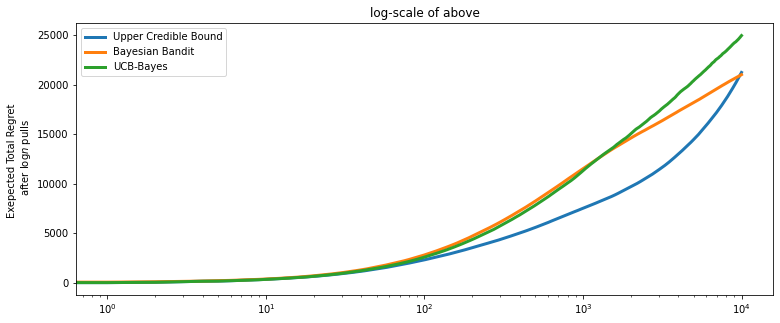

In [13]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3], 
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
            loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

10000번 정도 시행한 후에는 Thompson Sampling이 Regret이 가장 작은 것을 볼 수 있다.

#### References 

https://cxl.com/blog/bandit-tests/

http://www.economics.uci.edu/~ivan/asmb.874.pdf

https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf